In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Import libraries
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
import joblib  # For saving and loading models
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from time import sleep
from IPython.display import clear_output
import sys
import json
import matplotlib.pyplot as plt 
import seaborn as sns

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [6]:
# Load csv file without headers (assuming first row is data, not column names)
import pandas as pd

# Read the CSV file
df = pd.read_csv('Emotion Phrases.csv', encoding='ISO-8859-1', header=None)

# Manually assign column names
df.columns = ['Emotion', 'Text']

# Keep only relevant columns
df = df[['Emotion', 'Text']]

# Replace emotions as specified
df['Emotion'] = df['Emotion'].replace({'surprise': 'joy', 'disgust': 'anger'})

# Factorize category_id
df['emotion_id'], categories = pd.factorize(df['Emotion'])
df['emotion_id'] = df['emotion_id'] + 1

# Dropping all rows containing NaN
df = df.dropna()

# Save categories to a JSON file
with open('categories_best.json', 'w') as json_file:
    json.dump(categories.tolist(), json_file)

emotion_df = pd.read_csv('Emotion Words.csv', header=None)
emotion_dict = {row[0]: row[1] for index, row in emotion_df.iterrows()}

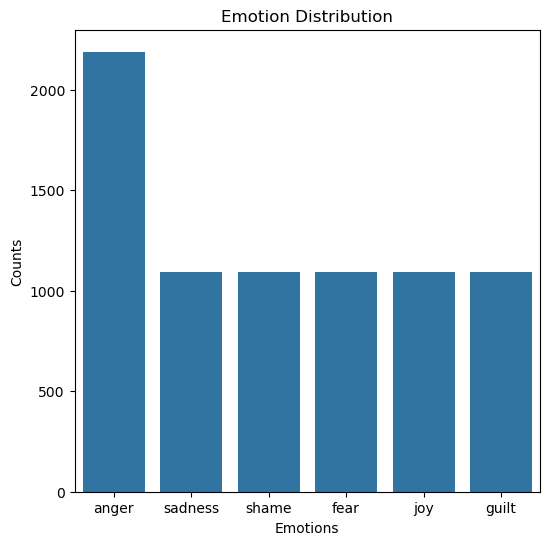

In [7]:
x = df['Emotion'].value_counts()

plt.figure(figsize=(6, 6))
sns.barplot(x=x.index, y=x.values)

plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.title('Emotion Distribution')
plt.show()

In [8]:
import spacy
import pytextrank
!python -m spacy download en_core_web_sm


nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank", last=True)

def summarize_text(text):
    if len(text) >= 500:
        doc = nlp(text)
        summary = []
        for p in doc._.phrases[:5]:
            summary.append(p.text)
        return ' '.join(summary) 
    else:
        return text 

df['Text'] = df['Text'].apply(summarize_text)

c:\Users\User\anaconda3\envs\datascience_project\Lib\site-packages


In [9]:
def preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

def stopword(string):
    return ' '.join([word for word in string.split() if word not in stopwords.words('english')])

wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    return " ".join([wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in word_pos_tags])

def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# Apply preprocessing to the comments
df['Text'] = df['Text'].apply(finalpreprocess)


Most common words for joy: [('friend', 185), ('get', 162), ('pass', 110), ('time', 108), ('year', 107), ('happy', 102), ('first', 99), ('felt', 98), ('go', 97), ('joy', 94)]


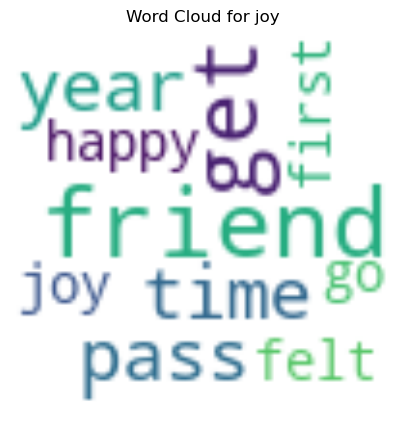

Most common words for fear: [('go', 200), ('night', 168), ('fear', 152), ('one', 135), ('afraid', 123), ('car', 122), ('alone', 116), ('home', 114), ('would', 113), ('friend', 105)]


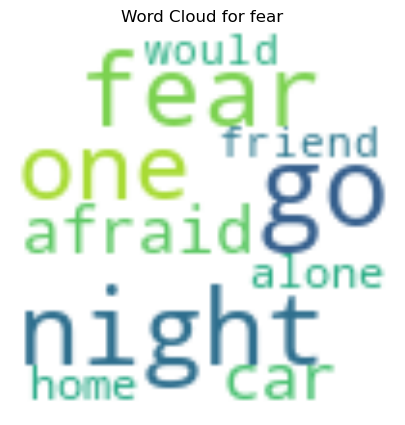

Most common words for anger: [('friend', 393), ('get', 223), ('disgust', 214), ('go', 211), ('one', 210), ('angry', 195), ('felt', 184), ('people', 172), ('saw', 164), ('tell', 151)]


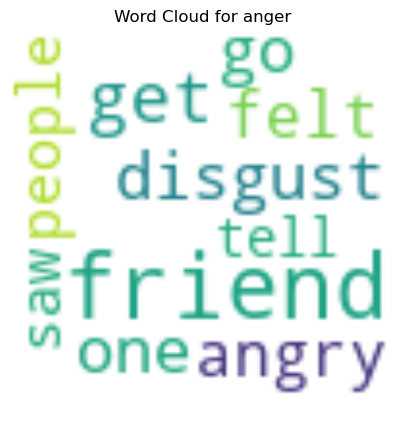

Most common words for sadness: [('friend', 234), ('die', 202), ('sad', 171), ('felt', 133), ('go', 113), ('year', 112), ('time', 103), ('leave', 92), ('father', 90), ('get', 84)]


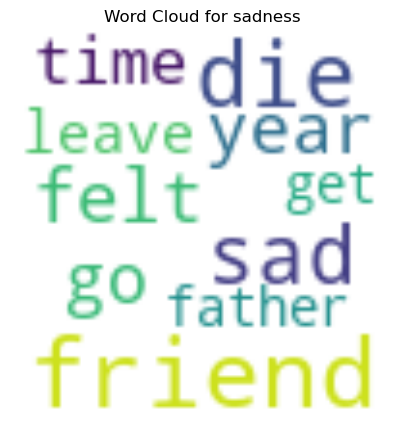

Most common words for shame: [('ashamed', 190), ('friend', 182), ('felt', 180), ('one', 100), ('go', 96), ('time', 88), ('tell', 87), ('say', 74), ('day', 73), ('get', 69)]


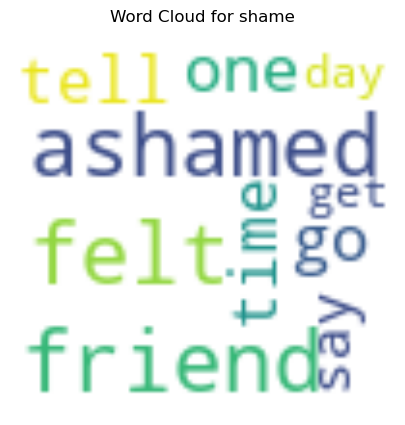

Most common words for guilt: [('felt', 221), ('friend', 218), ('guilty', 191), ('go', 169), ('mother', 120), ('get', 101), ('time', 99), ('one', 99), ('tell', 99), ('take', 86)]


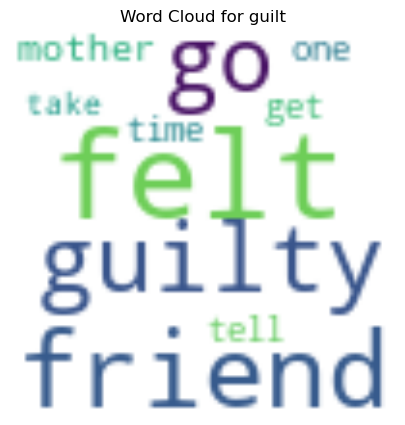

In [11]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

def create_word_clouds(df):
    unwanted_words = {'ã¡'}  # Set of unwanted words

    emotions = df['Emotion'].unique()
    for emotion in emotions:
        text = ' '.join(df[df['Emotion'] == emotion]['Text'])
        
        # Filter out unwanted words like 'ã¡'
        filtered_text = ' '.join([word for word in text.split() if word not in unwanted_words])

        # Calculate word frequencies
        word_freq = Counter(filtered_text.split())
        most_common_words = word_freq.most_common(10)
        print(f"Most common words for {emotion}: {most_common_words}")

        # Generate word cloud from word frequencies
        wc = WordCloud(
            background_color="white",
            width=100,
            height=100,
            max_words=10,
            relative_scaling=0.5,
            normalize_plurals=False,
        ).generate_from_frequencies(dict(most_common_words))

        # Display word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {emotion}')
        plt.show()

create_word_clouds(df)

In [5]:
# Oversample the minority class to address class imbalance
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['Text']], df['emotion_id'])

# Get the category we need for testing
X = X_resampled['Text']
y = y_resampled

# Create test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 90)
X_val, X_val_test, y_val, y_val_test = train_test_split(X_train, y_train, test_size=0.50, random_state=90)

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Define classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
}

# Initialize the results dictionary
results = {}

# Function to evaluate classifiers and return best classifier
def evaluate_classifiers(X_val, y_val, X_val_test, y_val_test):
    results.clear()  # Clear previous results
    for clf_name, clf in classifiers.items():
        # Create the pipeline
        pipeline = Pipeline([
            ('cv', TfidfVectorizer()),
            ('clf', clf)
        ])

        # Train the classifier
        pipeline.fit(X_val, y_val)

        # Validate the classifier
        y_val_pred = pipeline.predict(X_val_test)

        # Calculate accuracy on validation set
        accuracy = accuracy_score(y_val_test, y_val_pred)
        results[clf_name] = accuracy
        print(f"{clf_name} Validation Accuracy: {accuracy:.4f}")

    # Select the best classifier based on validation accuracy
    best_classifier = max(results, key=results.get)
    return best_classifier, results[best_classifier]

# Initial evaluation of classifiers
best_classifier, validation_accuracy = evaluate_classifiers(X_val, y_val, X_val_test, y_val_test)

# Loop until the validation accuracy is more than 80% or no improvement for three iterations
no_improvement_count = 0
previous_accuracy = validation_accuracy

while validation_accuracy <= 0.80:
    print(f"\nBest Classifier: {best_classifier} with Validation Accuracy: {validation_accuracy:.4f}")
    print("Retraining best classifier to improve accuracy...")

    # Here you can change hyperparameters to improve accuracy if needed.
    # Example: You can perform GridSearchCV to find the best parameters
    if best_classifier == 'Random Forest':
        param_grid = {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [None, 10, 20, 30],
        }
    elif best_classifier == 'Logistic Regression':
        param_grid = {
            'clf__C': [0.01, 0.1, 1, 10],
            'clf__solver': ['lbfgs', 'liblinear'],
        }

    # Create the pipeline for GridSearch
    pipeline = Pipeline([
        ('cv', TfidfVectorizer()),
        ('clf', classifiers[best_classifier])
    ])

    # Use GridSearchCV to find the best parameters
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_val, y_val)

    # Evaluate the best model from grid search on the validation set
    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val_test)
    validation_accuracy = accuracy_score(y_val_test, y_val_pred)

    # Check for improvement
    if validation_accuracy <= previous_accuracy:
        no_improvement_count += 1
    else:
        no_improvement_count = 0  # Reset if improvement is seen

    previous_accuracy = validation_accuracy

    # Break if no improvement for three iterations
    if no_improvement_count >= 3:
        print("No improvement in validation accuracy for 3 iterations. Stopping retraining.")
        break

# Finally, train the best classifier on the full training data (train + validation) and evaluate on the test set
print(f"\nFinalizing model: {best_classifier} with Validation Accuracy: {validation_accuracy:.4f}")
best_model.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy of {best_classifier}: {test_accuracy:.4f}")

Random Forest Validation Accuracy: 0.7084
Logistic Regression Validation Accuracy: 0.6699

Best Classifier: Random Forest with Validation Accuracy: 0.7084
Retraining best classifier to improve accuracy...

Best Classifier: Random Forest with Validation Accuracy: 0.7171
Retraining best classifier to improve accuracy...

Best Classifier: Random Forest with Validation Accuracy: 0.7171
Retraining best classifier to improve accuracy...

Best Classifier: Random Forest with Validation Accuracy: 0.7171
Retraining best classifier to improve accuracy...
No improvement in validation accuracy for 3 iterations. Stopping retraining.

Finalizing model: Random Forest with Validation Accuracy: 0.7171
Test Accuracy of Random Forest: 0.8177


In [10]:
joblib.dump(best_model, 'rf_best.joblib')

['rf_best.joblib']

In [31]:
from collections import Counter

def map_text_to_emotion_2(text, emotion_dict):
    words = text.split()  # Simple tokenization by splitting on spaces
    matched_emotions = []  # List to store matched emotions

    for word in words:
        if word in emotion_dict:
            matched_emotions.append(emotion_dict[word])  # Append the matched emotion
            print(word)

    # Count the occurrences of each emotion
    emotion_counts = Counter(matched_emotions)
    print(matched_emotions)

    # Check if there are any matched emotions
    if not emotion_counts:
        return None  # Return None if no emotions are matched

    # Get the emotion with the highest count
    most_common_emotion = emotion_counts.most_common(1)[0]  # Get the most common emotion
    print(most_common_emotion[0])
    return most_common_emotion[0]  # Return only the emotion

In [21]:
rf = Pipeline([('cv', TfidfVectorizer()),
               ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
              ])

# Train the random forest model on the training set
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Calculate the accuracy of the model
print(f"Accuracy is: {accuracy_score(y_pred,y_test)}")

Accuracy is: 0.8131505458238132
